In [1]:
from matplotlib import pyplot as plt
from itertools import product
# import seaborn as sns
import pandas as pd
import os.path as op
import argparse
import re
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from scipy import signal
from scipy.fft import fftshift
from bids import BIDSLayout
from statsmodels.stats.anova import AnovaRM

from util.io.ffr import *

In [2]:
def read_epochs(sub, desc):
    '''
    reads and concatenates epochs across runs
    '''
    from bids import BIDSLayout
    layout = BIDSLayout(BIDS_ROOT, derivatives = True)
    run = lambda f: int(re.findall('run-(\w+)_', f)[0])
    fnames = layout.get(
        return_type = 'filename',
        subject = sub, 
        desc = desc
        )
    print(fnames)
    fnames.sort(key = run)
    epochs_all = [mne.read_epochs(f) for f in fnames]
    for epochs in epochs_all:
        print(epochs.info['sfreq'])
    epochs = mne.concatenate_epochs(epochs_all)
    epochs = epochs.pick('eeg')
    return epochs

In [ ]:
### Load accuracies to add to data
accuracies = pd.read_csv('accuracies.csv')
sns.histplot(accuracies.accuracy)
med = np.median(accuracies.accuracy)
low_subs = list(accuracies.sub_num[accuracies.accuracy < med])
high_subs = list(accuracies.sub_num[accuracies.accuracy > med])
print(low_subs)
print(high_subs)

In [3]:
BIDS_ROOT = '../data/bids'
layout = BIDSLayout(BIDS_ROOT, derivatives = True, regex_search = 'forERP')
subs = layout.get_subjects(scope = 'erp')
subs.sort(key = int)
evokeds = pd.DataFrame()

for sub in subs:
    
    # Read epochs
    epochs = read_epochs(sub, 'forERP')
    
    # Compute evokeds 
    conditions = list(epochs.event_id.keys())
    chans = ['Cz', 'Fz', 'FCz', 'CPz', 'Pz']
    for c in conditions:
        target = c[0]
        tone = c[1]
        for chan in chans:
            uV = np.squeeze(epochs[c].average(picks = chan).get_data())
            t = np.arange(-273, 327)

            if int(sub) in high_subs:
                accuracy = 'high'
            elif int(sub) in low_subs:
                accuracy = 'low'
            else:
                accuracy = 'none'

            d = {
                'sub': sub,
                'chan': chan,
                'target': target,
                'accuracy': accuracy,
                'tone': tone,
                'msec': t,
                'uV': uV
            }

            # Bind into dataframe
            evoked = pd.DataFrame(d)
            evokeds = pd.concat([evokeds, evoked])
            evokeds = evokeds.reset_index(drop = True)

# evokeds.to_csv('evokeds.csv', index = False)
evokeds = pd.read_csv('evokeds.csv')

In [59]:
evokeds

sub chan  target accuracy  tone  msec            uV
0          3   Cz       1      low     1  -273 -1.781655e-08
1          3   Cz       1      low     1  -272 -2.357325e-08
2          3   Cz       1      low     1  -271 -3.427617e-08
3          3   Cz       1      low     1  -270 -4.183020e-08
4          3   Cz       1      low     1  -269 -5.010064e-08
...      ...  ...     ...      ...   ...   ...           ...
1052995   42   Pz       3     none     3   322  4.119855e-07
1052996   42   Pz       3     none     3   323  3.988742e-07
1052997   42   Pz       3     none     3   324  3.826440e-07
1052998   42   Pz       3     none     3   325  3.628893e-07
1052999   42   Pz       3     none     3   326  3.418009e-07

[1053000 rows x 7 columns]

### By target tone

In [5]:
evokeds_target_1 = evokeds[evokeds.target == 1]
evokeds_target_2 = evokeds[evokeds.target == 2]
evokeds_target_3 = evokeds[evokeds.target == 3]

(-50.0, 300.0)

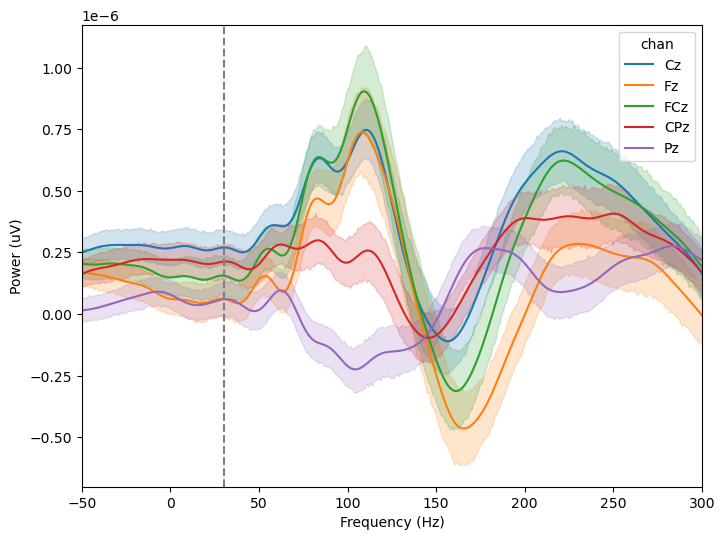

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_1, x = "msec", y = "uV", hue = "chan", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)

(-50.0, 300.0)

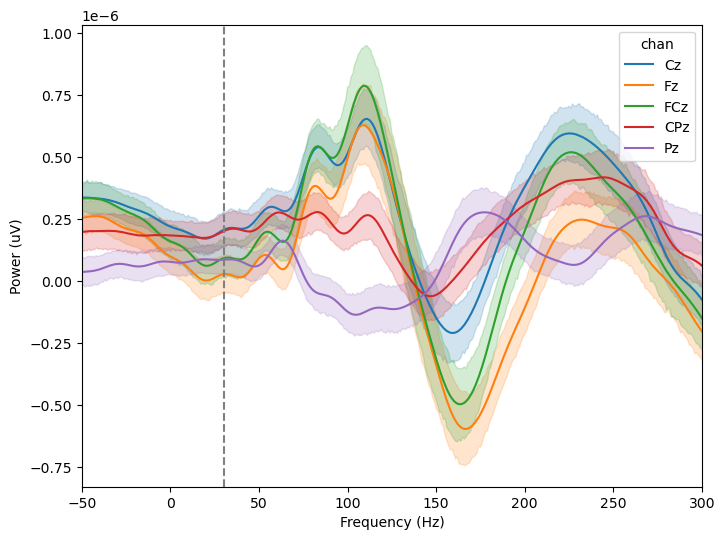

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_2, x = "msec", y = "uV", hue = "chan", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)

(-50.0, 300.0)

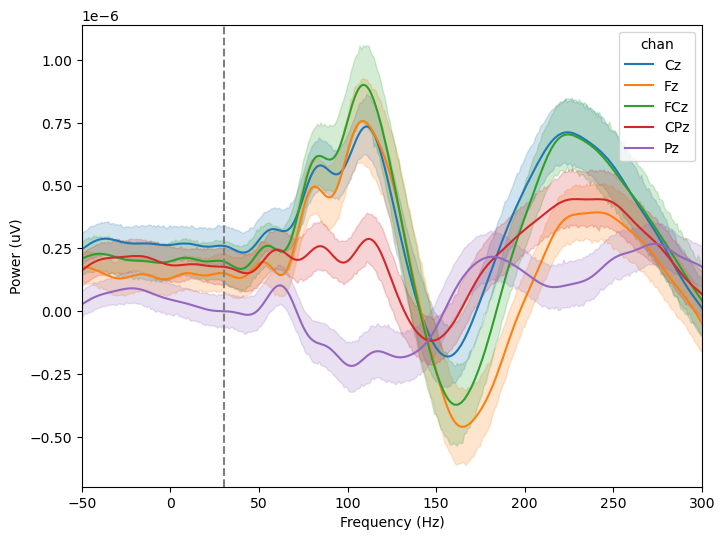

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_3, x = "msec", y = "uV", hue = "chan", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)

### By channel

Text(0.5, 1.0, 'Pz')

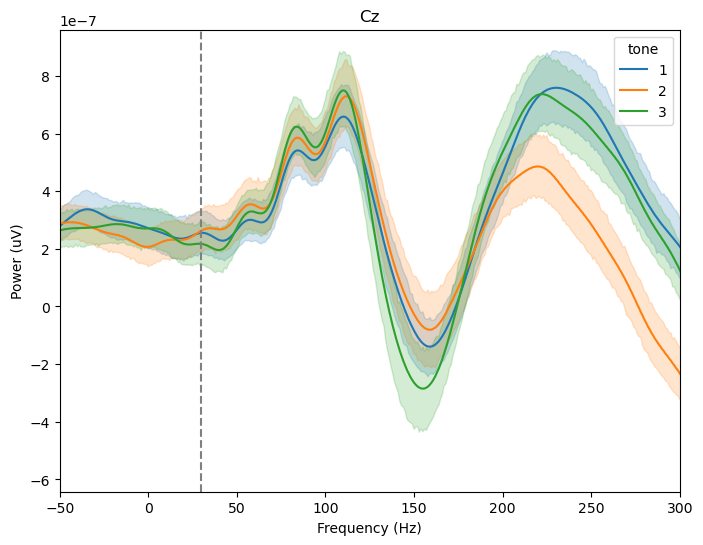

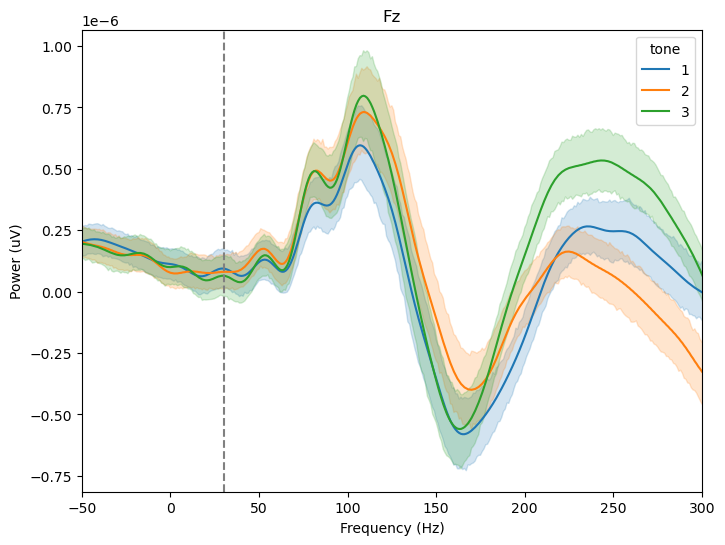

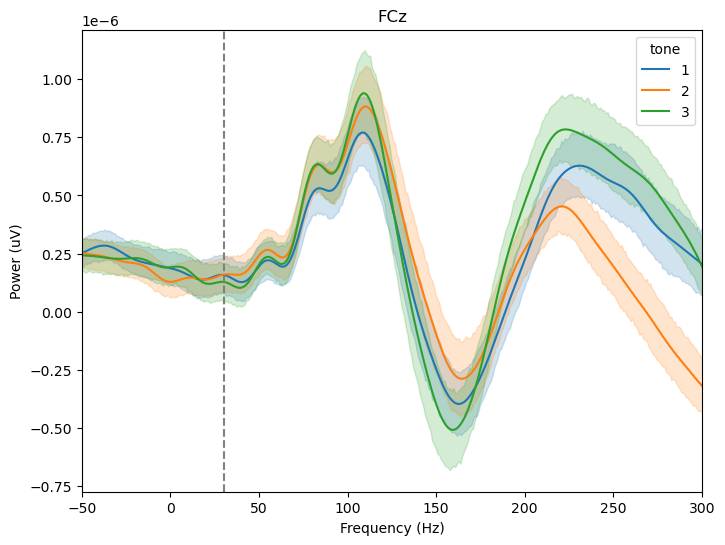

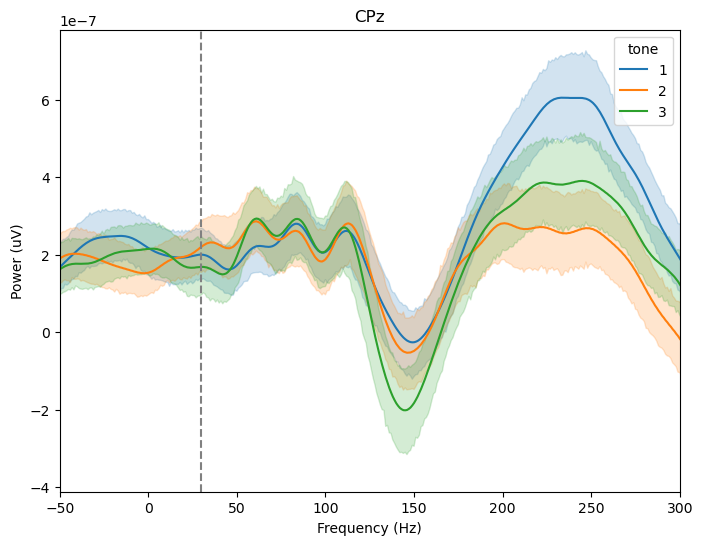

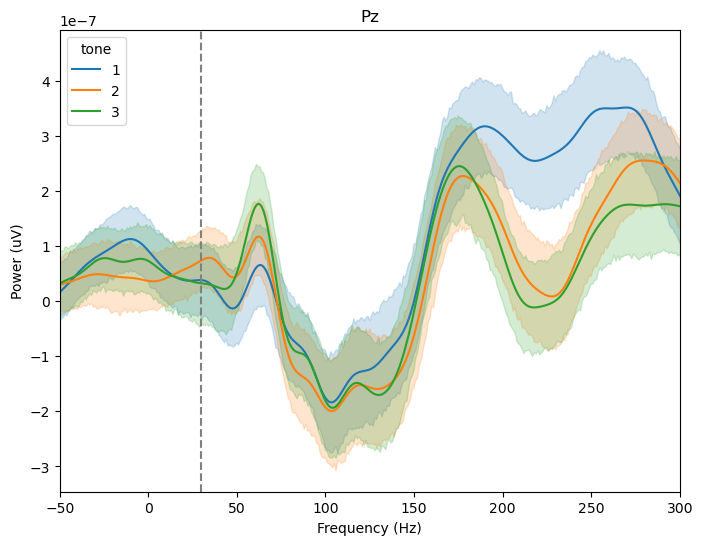

In [19]:
evokeds_target_Cz = evokeds[evokeds.chan == 'Cz']
evokeds_target_Fz = evokeds[evokeds.chan == 'Fz']
evokeds_target_FCz = evokeds[evokeds.chan == 'FCz']
evokeds_target_CPz = evokeds[evokeds.chan == 'CPz']
evokeds_target_Pz = evokeds[evokeds.chan == 'Pz']

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Cz, x = "msec", y = "uV", hue = "tone", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Cz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Fz, x = "msec", y = "uV", hue = "tone", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Fz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_FCz, x = "msec", y = "uV", hue = "tone", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('FCz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_CPz, x = "msec", y = "uV", hue = "tone", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('CPz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Pz, x = "msec", y = "uV", hue = "tone", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Pz')

### By channel by tone and target tone for tone 1

Text(0.5, 1.0, 'Pz')

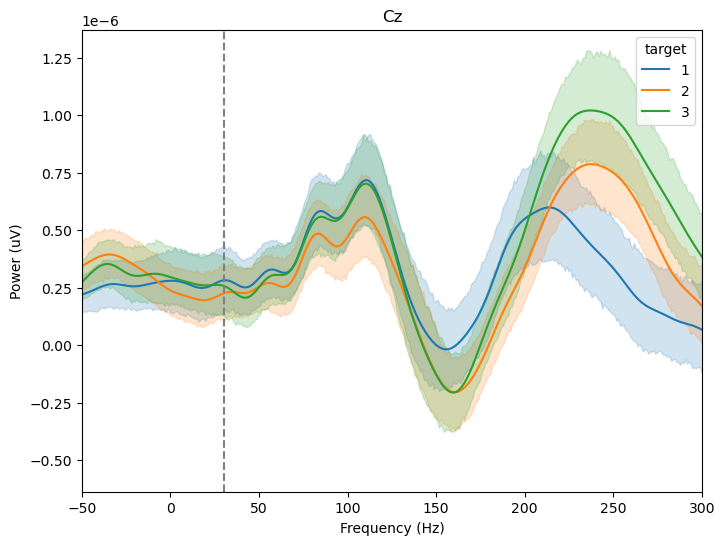

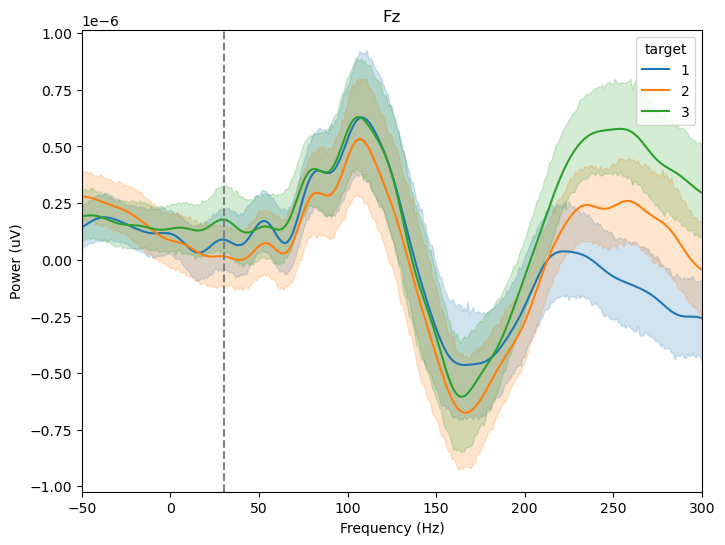

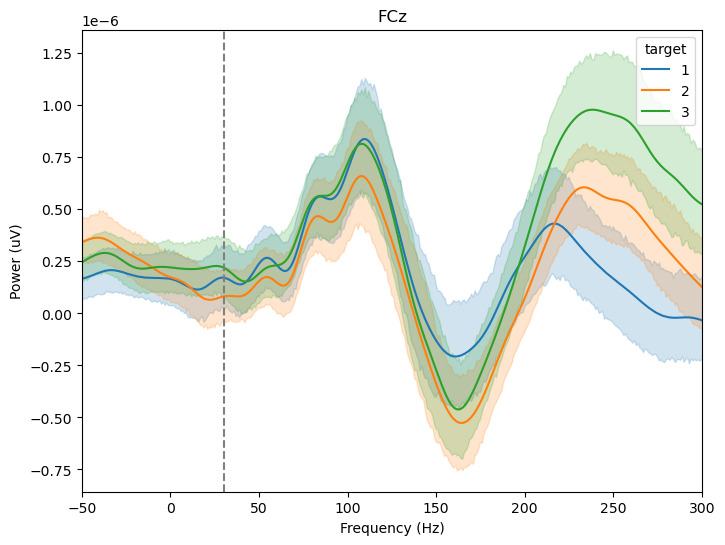

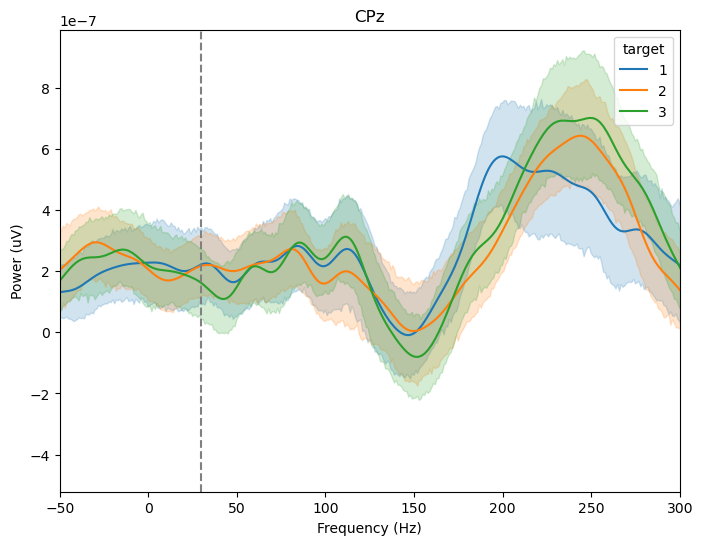

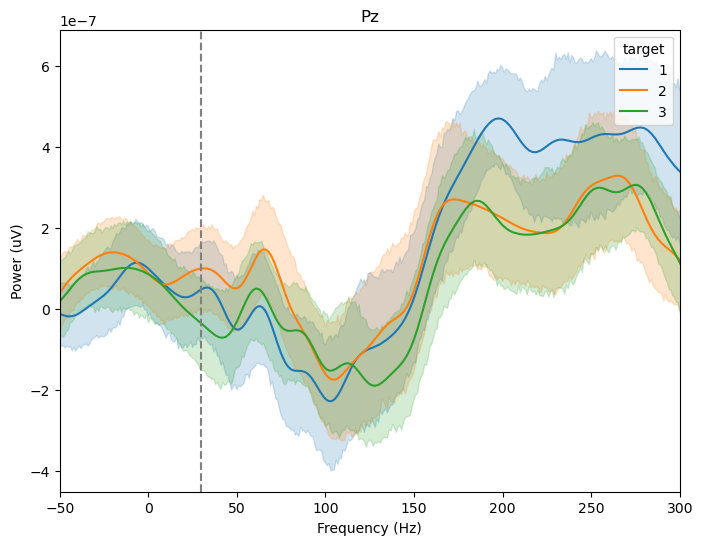

In [9]:
evokeds_tone_1 = evokeds[evokeds.tone == 1]
evokeds_target_Cz = evokeds_tone_1[evokeds_tone_1.chan == 'Cz']
evokeds_target_Fz = evokeds_tone_1[evokeds_tone_1.chan == 'Fz']
evokeds_target_FCz = evokeds_tone_1[evokeds_tone_1.chan == 'FCz']
evokeds_target_CPz = evokeds_tone_1[evokeds_tone_1.chan == 'CPz']
evokeds_target_Pz = evokeds_tone_1[evokeds_tone_1.chan == 'Pz']

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Cz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Cz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Fz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Fz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_FCz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('FCz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_CPz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('CPz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Pz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Pz')

### By channel and target tone for tone 2

Text(0.5, 1.0, 'Pz')

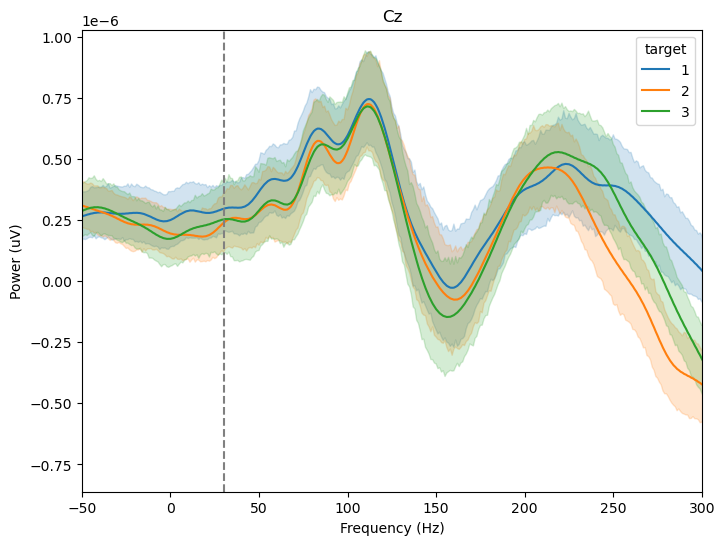

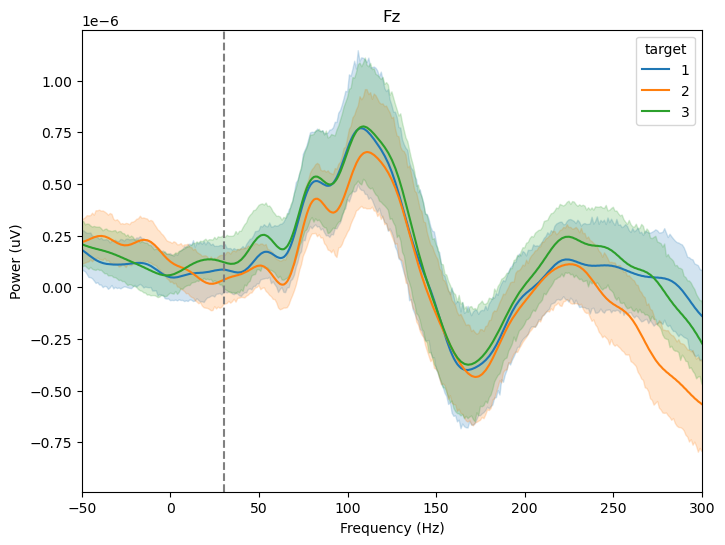

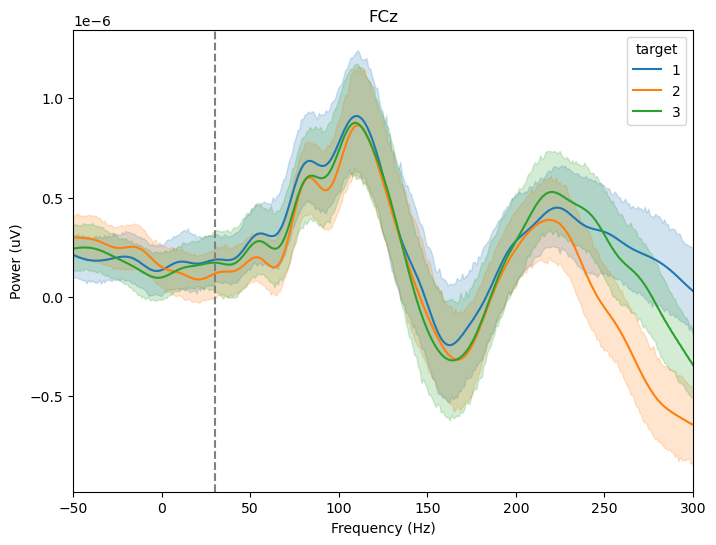

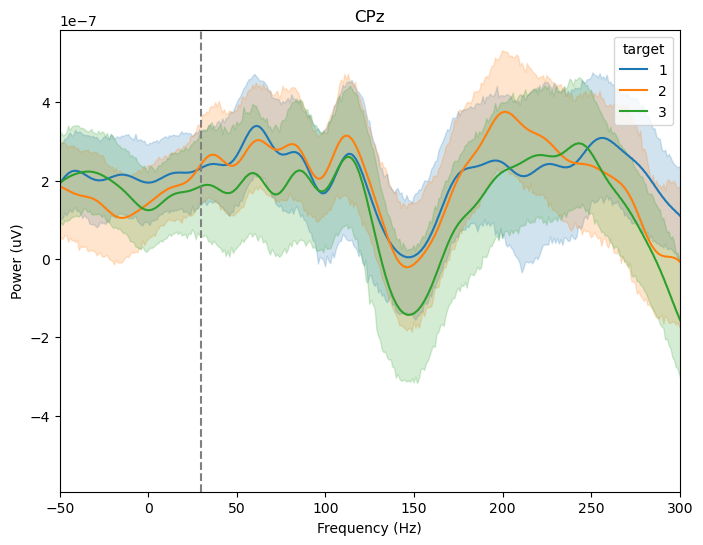

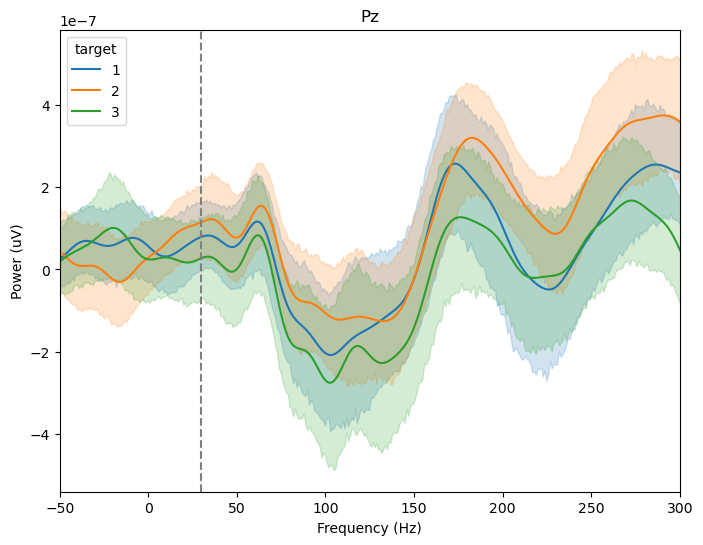

In [10]:
evokeds_tone_2 = evokeds[evokeds.tone == 2]
evokeds_target_Cz = evokeds_tone_2[evokeds_tone_2.chan == 'Cz']
evokeds_target_Fz = evokeds_tone_2[evokeds_tone_2.chan == 'Fz']
evokeds_target_FCz = evokeds_tone_2[evokeds_tone_2.chan == 'FCz']
evokeds_target_CPz = evokeds_tone_2[evokeds_tone_2.chan == 'CPz']
evokeds_target_Pz = evokeds_tone_2[evokeds_tone_2.chan == 'Pz']

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Cz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Cz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Fz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Fz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_FCz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('FCz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_CPz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('CPz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Pz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Pz')

### By channel and target tone for tone 3

Text(0.5, 1.0, 'Pz')

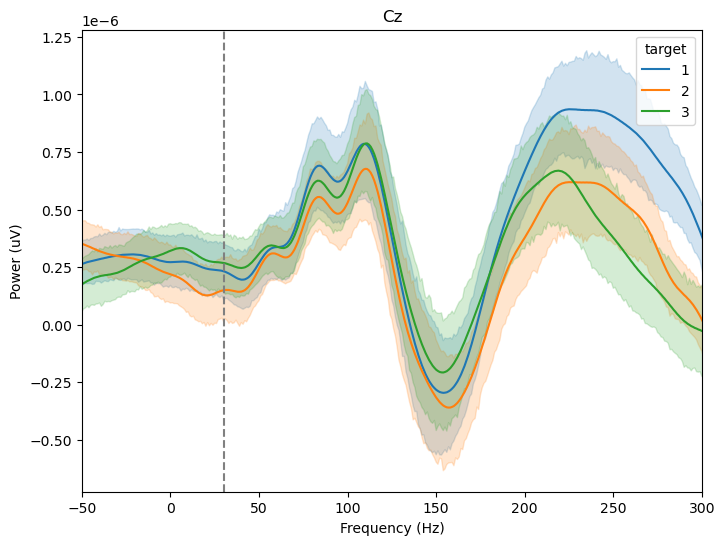

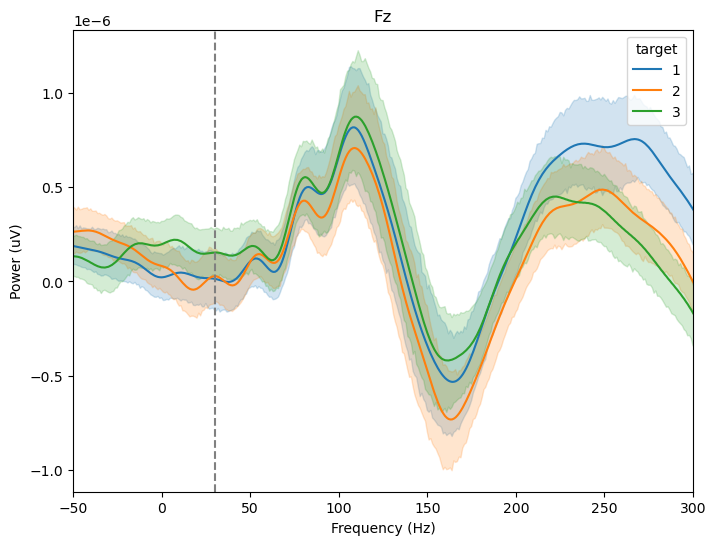

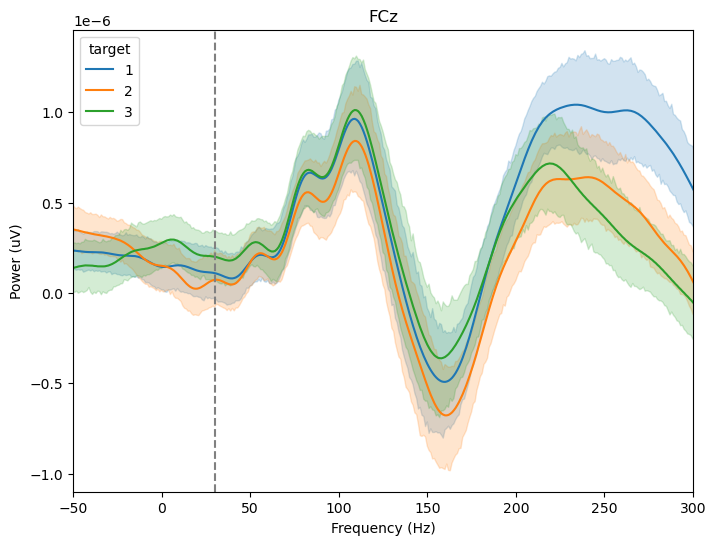

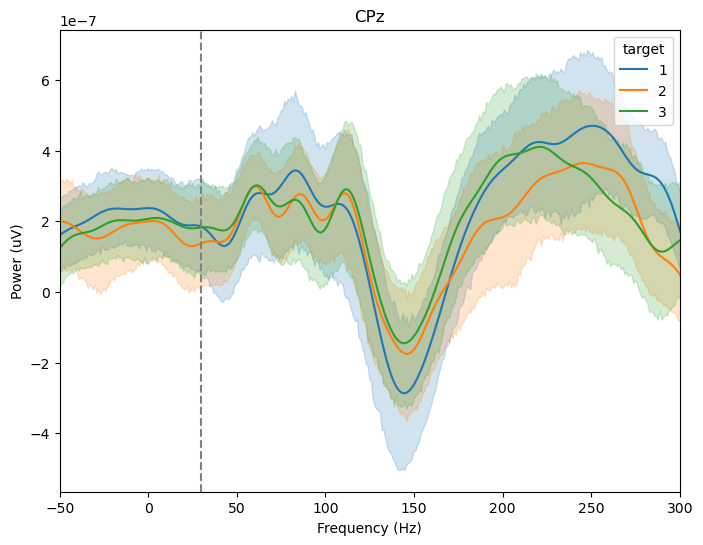

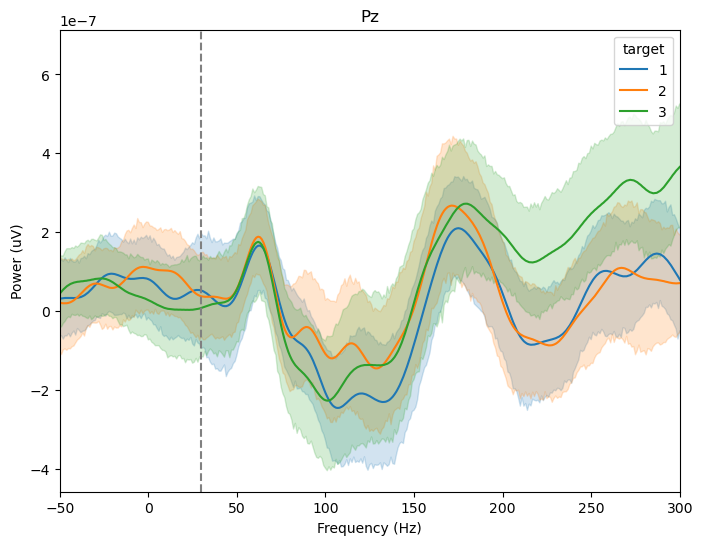

In [11]:
evokeds_tone_3 = evokeds[evokeds.tone == 3]
evokeds_target_Cz = evokeds_tone_3[evokeds_tone_3.chan == 'Cz']
evokeds_target_Fz = evokeds_tone_3[evokeds_tone_3.chan == 'Fz']
evokeds_target_FCz = evokeds_tone_3[evokeds_tone_3.chan == 'FCz']
evokeds_target_CPz = evokeds_tone_3[evokeds_tone_3.chan == 'CPz']
evokeds_target_Pz = evokeds_tone_3[evokeds_tone_3.chan == 'Pz']

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Cz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Cz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Fz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Fz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_FCz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('FCz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_CPz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('CPz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Pz, x = "msec", y = "uV", hue = "target", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Pz')

# Factor in accuracies

Text(0.5, 1.0, 'Pz')

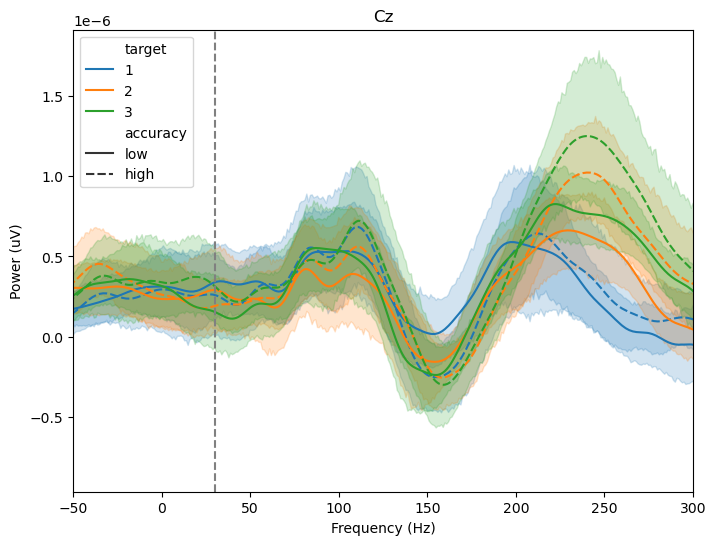

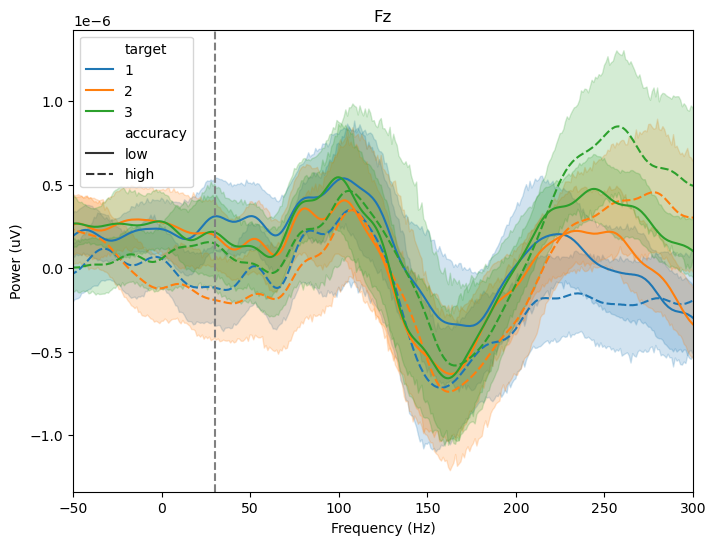

In [ ]:
evokeds_tone_1 = evokeds[evokeds.tone == 1] 
evokeds_tone_1 = evokeds_tone_1[evokeds_tone_1.accuracy != 'none']
# evokeds_tone_1 = evokeds_tone_1[evokeds_tone_1.target == 1]
evokeds_target_Cz = evokeds_tone_1[evokeds_tone_1.chan == 'Cz']
evokeds_target_Fz = evokeds_tone_1[evokeds_tone_1.chan == 'Fz']
evokeds_target_FCz = evokeds_tone_1[evokeds_tone_1.chan == 'FCz']
evokeds_target_CPz = evokeds_tone_1[evokeds_tone_1.chan == 'CPz']
evokeds_target_Pz = evokeds_tone_1[evokeds_tone_1.chan == 'Pz']

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Cz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Cz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Fz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Fz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_FCz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('FCz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_CPz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('CPz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Pz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Pz')

Text(0.5, 1.0, 'Pz')

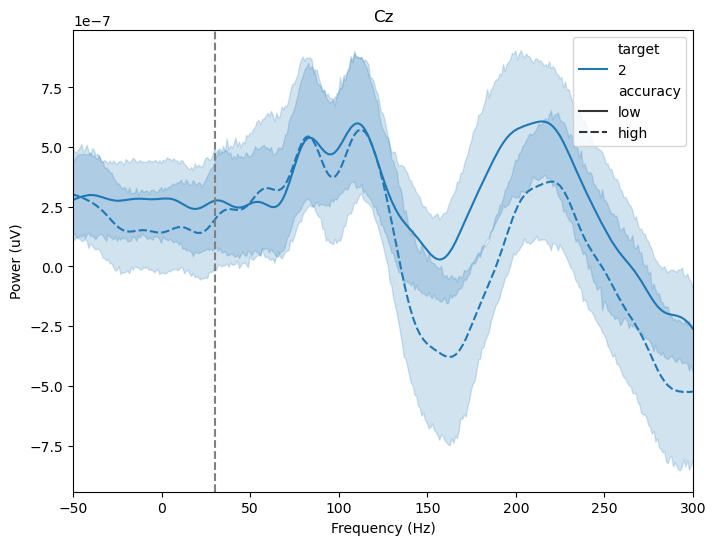

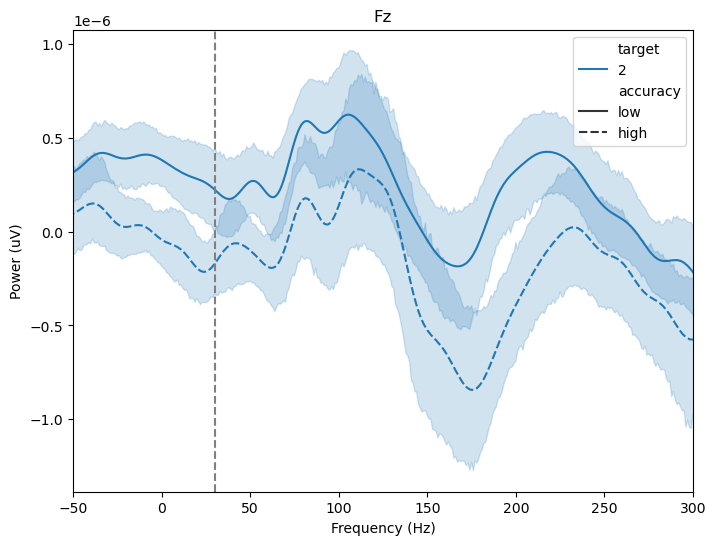

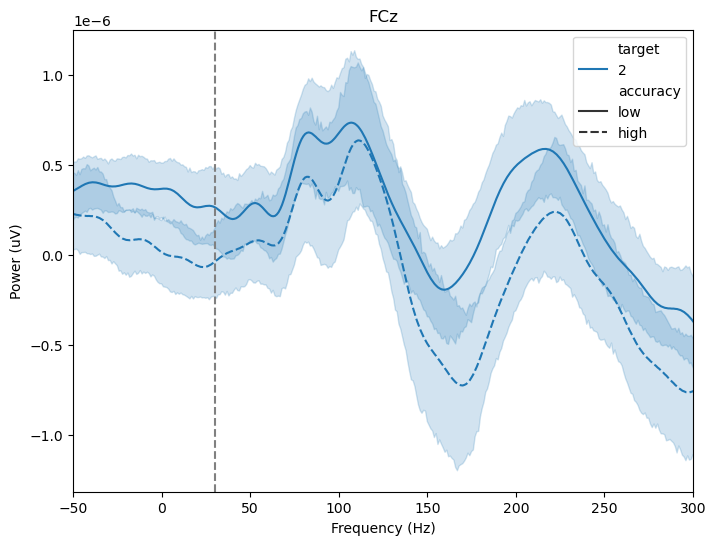

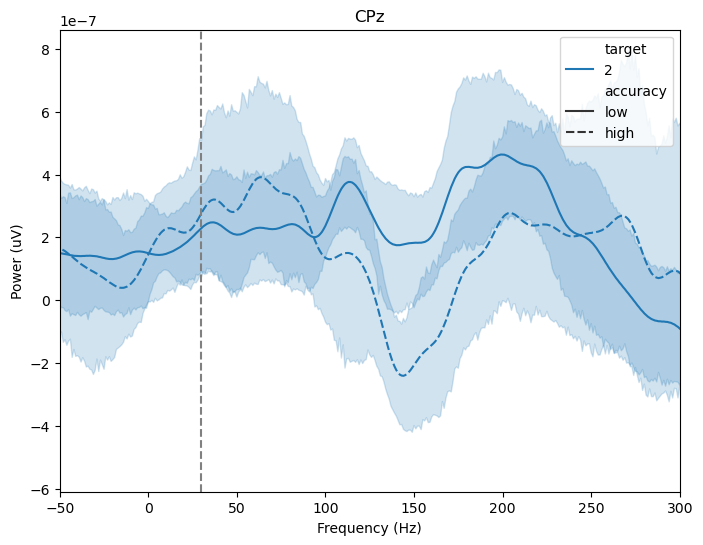

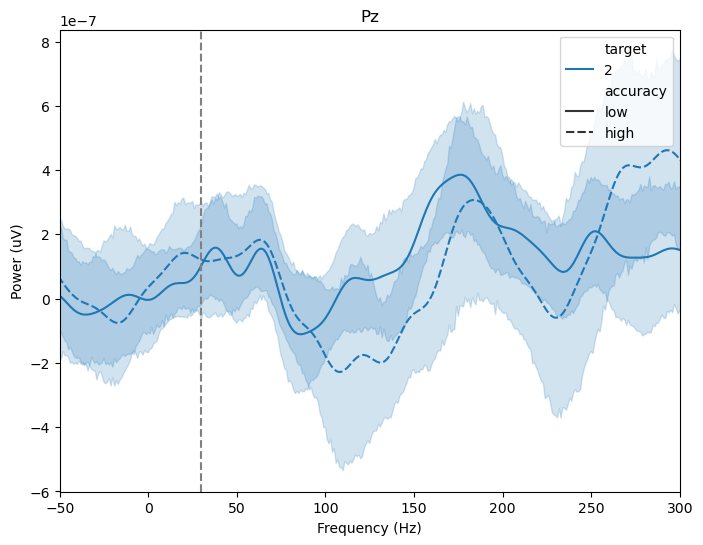

In [66]:
evokeds_tone_2 = evokeds[evokeds.tone == 2] 
evokeds_tone_2 = evokeds_tone_2[evokeds_tone_2.accuracy != 'none']
evokeds_tone_2 = evokeds_tone_2[evokeds_tone_2.target == 2]
evokeds_target_Cz = evokeds_tone_2[evokeds_tone_2.chan == 'Cz']
evokeds_target_Fz = evokeds_tone_2[evokeds_tone_2.chan == 'Fz']
evokeds_target_FCz = evokeds_tone_2[evokeds_tone_2.chan == 'FCz']
evokeds_target_CPz = evokeds_tone_2[evokeds_tone_2.chan == 'CPz']
evokeds_target_Pz = evokeds_tone_2[evokeds_tone_2.chan == 'Pz']

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Cz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Cz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Fz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Fz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_FCz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('FCz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_CPz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('CPz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Pz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Pz')

Text(0.5, 1.0, 'Pz')

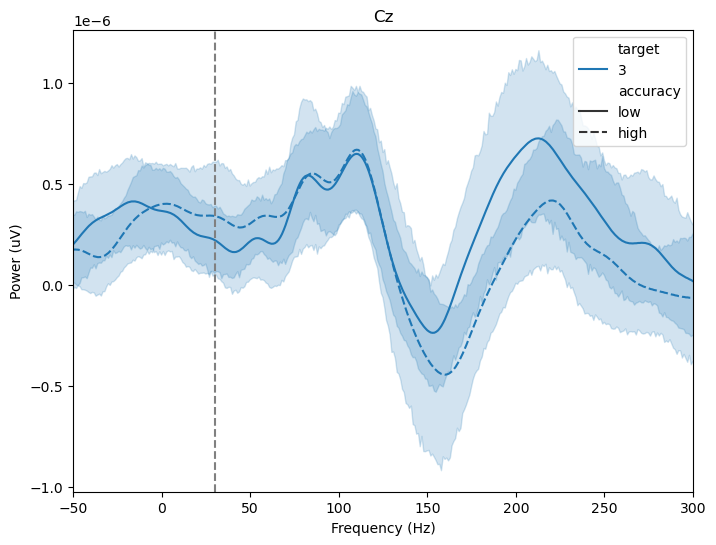

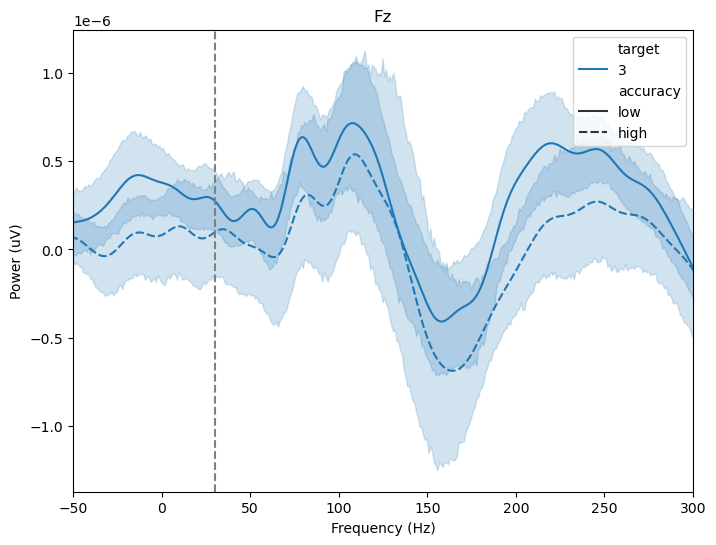

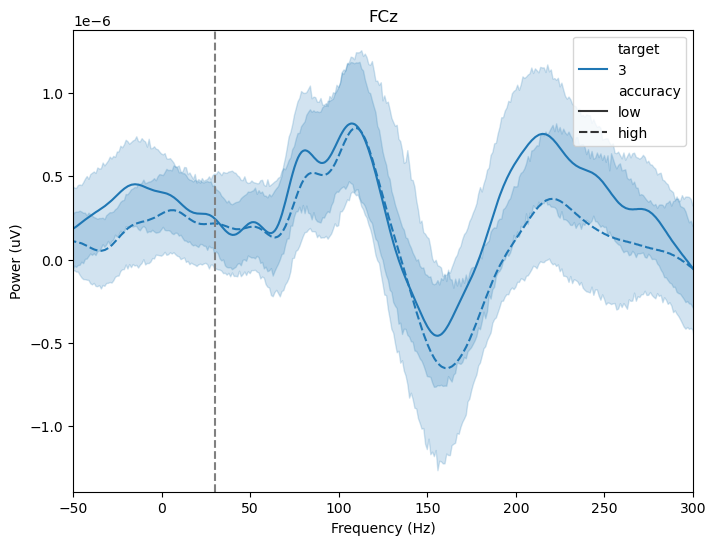

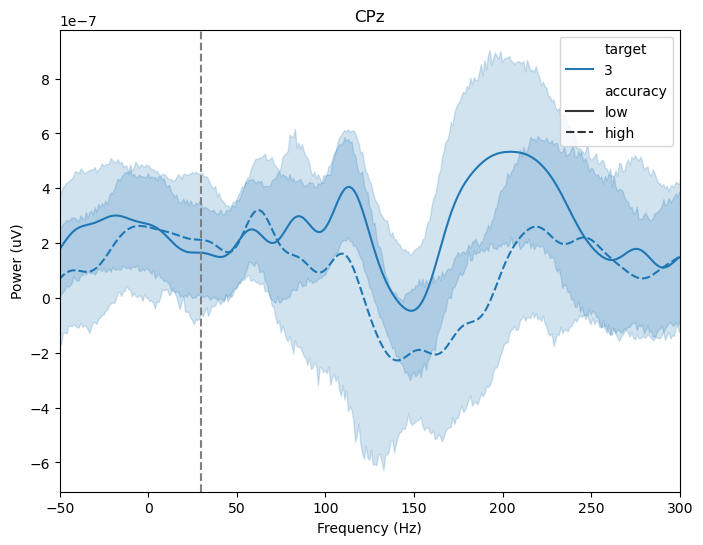

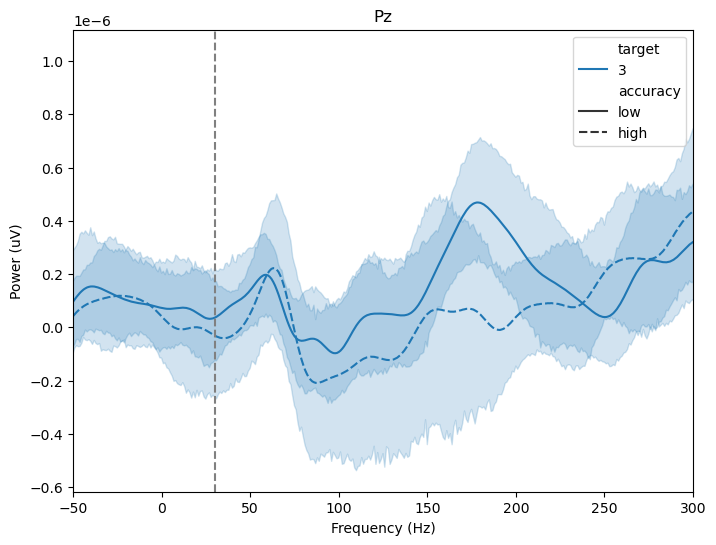

In [67]:
evokeds_tone_3 = evokeds[evokeds.tone == 3] 
evokeds_tone_3 = evokeds_tone_3[evokeds_tone_3.accuracy != 'none']
evokeds_tone_3 = evokeds_tone_3[evokeds_tone_3.target == 3]
evokeds_target_Cz = evokeds_tone_3[evokeds_tone_3.chan == 'Cz']
evokeds_target_Fz = evokeds_tone_3[evokeds_tone_3.chan == 'Fz']
evokeds_target_FCz = evokeds_tone_3[evokeds_tone_3.chan == 'FCz']
evokeds_target_CPz = evokeds_tone_3[evokeds_tone_3.chan == 'CPz']
evokeds_target_Pz = evokeds_tone_3[evokeds_tone_3.chan == 'Pz']

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Cz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Cz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Fz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Fz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_FCz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('FCz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_CPz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('CPz')

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.lineplot(data = evokeds_target_Pz, x = "msec", y = "uV", hue = "target", style = "accuracy", palette = 'tab10', ax = ax)
graph.axvline(30, linestyle = 'dashed', color = 'gray')
graph.set_ylabel("Power (uV)")
graph.set_xlabel("Frequency (Hz)")
graph.set_xlim(-50, 300)
graph.set_title('Pz')

In [20]:
np.shape(np.arange(-300, 300))

(600,)

In [15]:
np.shape(d['uV'])

(600,)

In [14]:
np.shape(d['msec'])

(3001,)

In [15]:
np.shape(epochs.get_data())

/scratch/local/jobs/18033977/ipykernel_3210970/3250172744.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  np.shape(epochs.get_data())


(4172, 62, 97)

In [150]:
# evokeds_Cz = evokeds[evokeds.chan == 'Cz']
sns.lineplot(evokeds_Cz, x = 'msec', y = 'uV')

chan   msec            uV
0         Cz -250.0  1.634980e-09
1         Cz -249.8  5.974834e-09
2         Cz -249.6  9.365589e-09
3         Cz -249.4  1.170717e-08
4         Cz -249.2  1.284131e-08
...      ...    ...           ...
4940791   Cz  299.2 -1.133472e-07
4940792   Cz  299.4 -9.912327e-08
4940793   Cz  299.6 -8.308423e-08
4940794   Cz  299.8 -6.650459e-08
4940795   Cz  300.0 -5.052788e-08

[990360 rows x 3 columns]

In [138]:
np.shape(d['uV'])

(1, 2751)

In [52]:
np.shape(sub_evokeds['11'].get_data())
np.shape(epochs['11'].average(picks = ['Cz', 'Fz', 'FCz', 'CPz', 'Pz']).get_data())

(5, 2751)

In [126]:
sub_evokeds.pick_channels(['Cz'])

AttributeError: 'dict' object has no attribute 'pick_channels'

In [88]:
evokeds_tmp = []
for evoked in evokeds['11']:
    if evoked.nave > 300 and len(evoked.ch_names) == 5:
        evokeds_tmp.append(evoked.get_data())
        print(np.shape(evoked.get_data()))
# np.shape(evokeds_tmp)

(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)
(5, 2751)


In [72]:
# graph = sns.lineplot(data = evokeds_tmp, x = "freq", y = "dB", hue = "stim", palette = 'tab10', ax = ax)

605

In [124]:
t = np.arange(-250, 300 + (1000/5000), 1000/5000)
d = {'chan': 'a',
     'msec': t,
     'uV': evokeds_tmp[1,1,:]}
pd.DataFrame(d)

chan   msec            uV
0       a -250.0  5.309744e-08
1       a -249.8  5.542247e-08
2       a -249.6  6.144482e-08
3       a -249.4  7.067082e-08
4       a -249.2  8.204603e-08
...   ...    ...           ...
2746    a  299.2 -9.293357e-08
2747    a  299.4 -7.835354e-08
2748    a  299.6 -5.848982e-08
2749    a  299.8 -3.532298e-08
2750    a  300.0 -1.122975e-08

[2751 rows x 3 columns]

In [96]:
0.0002*2751 # msec per step

0.5502

In [122]:
print(np.shape(evokeds_tmp))
evokeds_tmp = np.array(evokeds_tmp)
np.shapeevokeds_tmp[:,1,:]

(31, 5, 2751)


array([[-6.81802411e-09, -5.57057282e-09, -9.82747846e-10, ...,
        -1.34224504e-07, -1.57031149e-07, -1.77878038e-07],
       [ 5.30974436e-08,  5.54224692e-08,  6.14448224e-08, ...,
        -5.84898159e-08, -3.53229799e-08, -1.12297528e-08],
       [ 7.26648591e-08,  8.80032184e-08,  1.03072587e-07, ...,
        -8.02156429e-08, -1.24337720e-07, -1.60246726e-07],
       ...,
       [-4.31813969e-08, -1.21789350e-08,  1.54020724e-08, ...,
        -8.06038487e-08, -6.49767575e-08, -5.27885116e-08],
       [-3.85256449e-08, -4.68155293e-08, -5.49563198e-08, ...,
         4.00586102e-09,  1.48015121e-08,  2.30255234e-08],
       [-1.12017723e-07, -9.78876104e-08, -7.88791705e-08, ...,
        -6.05447277e-08, -9.16587993e-09,  3.71647899e-08]])

In [101]:
0.0002*2751

0.5502

combining channels using "mean"
combining channels using "mean"


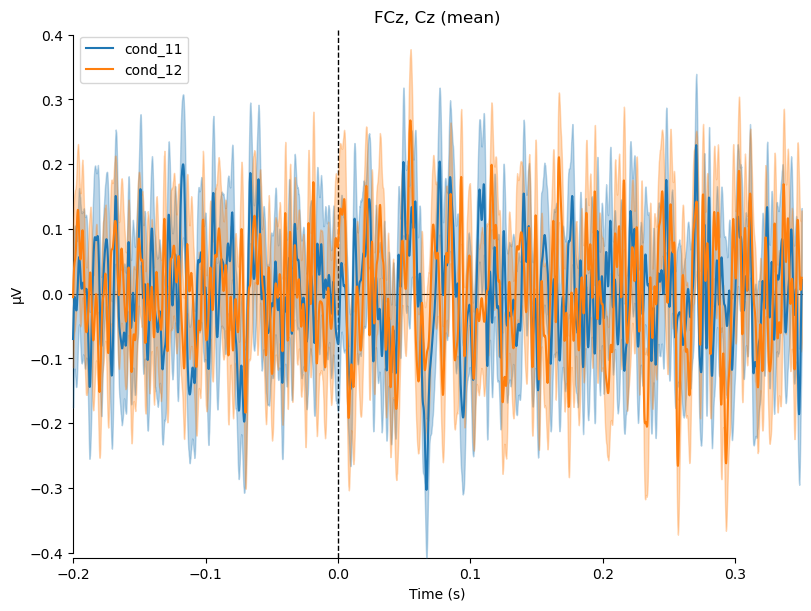

[<Figure size 800x600 with 1 Axes>]

In [37]:
evokeds_d = dict(
    cond_11=list(epochs["11"].iter_evoked()),
    cond_12=list(epochs["21"].iter_evoked()),
)
mne.viz.plot_compare_evokeds(evokeds_d, combine="mean", picks=picks)

In [23]:
evokeds

{'11': [<Evoked | '11' (average, N=789), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
  <Evoked | '11' (average, N=176), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
  <Evoked | '11' (average, N=218), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
  <Evoked | '11' (average, N=668), -0.2 – 0.35 s, baseline -0.2 – 0 s, 61 ch, ~1.4 MB>,
  <Evoked | '11' (average, N=634), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
  <Evoked | '11' (average, N=633), -0.2 – 0.35 s, baseline -0.2 – 0 s, 61 ch, ~1.4 MB>,
  <Evoked | '11' (average, N=522), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
  <Evoked | '11' (average, N=267), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
  <Evoked | '11' (average, N=357), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
  <Evoked | '11' (average, N=364), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
  <Evoked | '11' (average, N=443), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
  <Evoked | '11' (average,

In [38]:
sub_evokeds

{'11': <Evoked | '11' (average, N=176), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
 '12': <Evoked | '12' (average, N=173), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
 '13': <Evoked | '13' (average, N=167), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
 '21': <Evoked | '21' (average, N=82), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
 '22': <Evoked | '22' (average, N=88), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
 '23': <Evoked | '23' (average, N=100), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
 '31': <Evoked | '31' (average, N=190), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
 '32': <Evoked | '32' (average, N=183), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
 '33': <Evoked | '33' (average, N=173), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>}

In [37]:
evokeds = {'11': list(),
           '12': list(),
           '13': list(),
           '21': list(),
           '22': list(),
           '23': list(),
           '31': list(),
           '32': list(),
           '33': list()}
evokeds

{'11': [],
 '12': [],
 '13': [],
 '21': [],
 '22': [],
 '23': [],
 '31': [],
 '32': [],
 '33': []}

In [40]:
# {c:evokeds[str(c)].append([sub_evokeds[c]]) for c in conditions}
# {print([sub_evokeds[c]]) for c in conditions}
{print(evokeds[str(c)]) for c in conditions}

[[<Evoked | '11' (average, N=176), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>]]
[[<Evoked | '12' (average, N=173), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>]]
[[<Evoked | '13' (average, N=167), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>]]
[[<Evoked | '21' (average, N=82), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>]]
[[<Evoked | '22' (average, N=88), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>]]
[[<Evoked | '23' (average, N=100), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>]]
[[<Evoked | '31' (average, N=190), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>]]
[[<Evoked | '32' (average, N=183), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>]]
[[<Evoked | '33' (average, N=173), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>]]


{None}

In [59]:
evokeds = {'11': list(),
           '12': list(),
           '13': list(),
           '21': list(),
           '22': list(),
           '23': list(),
           '31': list(),
           '32': list(),
           '33': list()}
for i in range(3):
    for c in conditions:
        evokeds[c].append(sub_evokeds[c])
evokeds['11']

[<Evoked | '11' (average, N=176), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
 <Evoked | '11' (average, N=176), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>,
 <Evoked | '11' (average, N=176), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>]

[[<Evoked | '11' (average, N=176), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>],
 [<Evoked | '11' (average, N=176), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>],
 [<Evoked | '11' (average, N=176), -0.2 – 0.35 s, baseline -0.2 – 0 s, 62 ch, ~1.4 MB>]]